In [ ]:
pip install pretty_confusion_matrix

In [ ]:
from IPython.core.display import Pretty
#Data
import pandas as pd
import numpy as np

#Wavelet Transform
import pywt

#Train and Test Split
from sklearn.model_selection import train_test_split

#CNN and LSTM Model
import keras
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from keras.layers import Conv1D, LSTM, Input, MaxPool1D, MaxPooling1D, Dropout, AvgPool1D, Reshape, Concatenate, Dense, Flatten

#Metrics
from sklearn.metrics import confusion_matrix, recall_score, precision_score

#Visualization
import seaborn as sns
import matplotlib.pyplot as plt
#from pretty_confusion_matrix import pp_matrix
from keras.utils.vis_utils import plot_model

In [ ]:
#Import Data
x1 = pd.read_csv('https://github.com/ascdavia/TCC_Engenharia_de_Controle_e_Automacao/blob/main/Database/sEMG_Basic_Hand_movements_upatras_csv_files/Database_1/df1_mov_all.csv?raw=true', compression = None)
x1 = x1.drop(x1.columns[0], axis=1)


In [ ]:
#Maximum decomposition level
decUtil = pywt.dwt_max_level(3000, 'db2')
decUtil

9

In [ ]:
#Define Wavelet Transform Function

def waveletTransformFourLevels(df):

  aux_df = ()
  aux_df = pd.DataFrame(aux_df)

  for i in range (len(df)):
    aux = df.loc[i]
    cA4, cD4, cD3, cD2, cD1= pywt.wavedec(aux,'db2', level = 4)
    cA4 = pd.DataFrame(cA4).T
    cD4 = pd.DataFrame(cD4).T
    cD3 = pd.DataFrame(cD3).T
    cD2 = pd.DataFrame(cD2).T
    cD1 = pd.DataFrame(cD1).T
    aux_df2 = pd.concat([cA4,cD4,cD3,cD2,cD1], axis=1)
    aux_df = pd.concat([aux_df,aux_df2])

  c = list(range(0, 3010, 1))
  aux_df.set_axis(c, axis='columns', inplace=True)
  aux_df = aux_df.reset_index(drop=True)

  return (aux_df)

In [ ]:
#Wavelet Transform Application
x = waveletTransformFourLevels(x1)
x = pd.DataFrame(x)

<ipython-input-5-3079fd124878>:20: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  aux_df.set_axis(c, axis='columns', inplace=True)


In [ ]:
#Reshape
x = x.values.reshape(x.shape[0], x.shape[1], 1)

In [ ]:
#Labels
base = np.ones((150,1), dtype=np.int64)
m_cyl = base*0
m_hook = base*1
m_lat = base*2
m_palm = base*3
m_spher = base*4
m_tip = base*5

In [ ]:
y = np.vstack([m_cyl,m_hook,m_lat,m_palm,m_spher,m_tip])
y = pd.DataFrame(y)

In [ ]:
#Train, test and validation split
x_train, x_aux, y_train, y_aux = train_test_split(x,y, test_size=0.30, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_aux, y_aux, test_size=0.50, random_state=23)

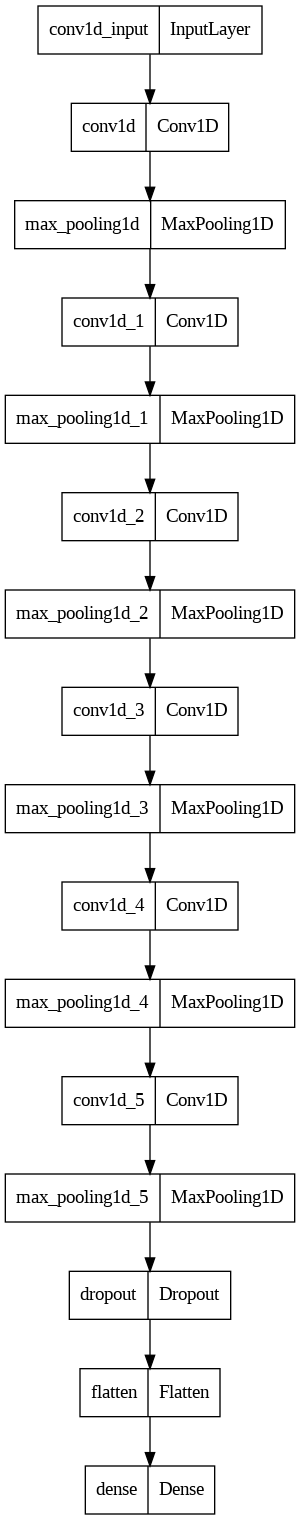

In [ ]:
#CNN Model

seq_len = 3010
lr = 0.00001

n_classes = 6
n_channels = 1

opt = Adam(learning_rate=lr)

cnn_model = Sequential()
cnn_model.add(Conv1D(filters=4, kernel_size=2, strides=1, padding='same', activation='relu', input_shape=(seq_len, n_channels)))
cnn_model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
cnn_model.add(Conv1D(filters=8, kernel_size=2, strides=1, padding='same', activation='relu'))
cnn_model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
cnn_model.add(Conv1D(filters=16, kernel_size=2, strides=1, padding='same', activation='relu'))
cnn_model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
cnn_model.add(Conv1D(filters=32, kernel_size=2, strides=1, padding='same', activation='relu'))
cnn_model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
cnn_model.add(Conv1D(filters=64, kernel_size=2, strides=1, padding='same', activation='relu'))
cnn_model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
cnn_model.add(Conv1D(filters=128, kernel_size=2, strides=1, padding='same', activation='relu'))
cnn_model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
cnn_model.add(Dropout(0.2))
cnn_model.add(Flatten())
cnn_model.add(Dense(n_classes, activation='softmax'))
cnn_model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

plot_model(cnn_model, to_file='model.png')


In [ ]:
print(cnn_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 3010, 4)           12        
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1505, 4)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 1505, 8)           72        
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 753, 8)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 753, 16)           272       
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 377, 16)          0

In [ ]:
#Fit CNN Model
batch_size = 100
epochs = 2500

history_cnn = cnn_model.fit(x_train,
                            y_train,
                            epochs=epochs,
                            batch_size=batch_size,
                            verbose=True,
                            validation_data=(x_val, y_val))

In [ ]:
plt.plot(history_cnn.history['loss'])
plt.plot(history_cnn.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
avaliacao = cnn_model.evaluate(x_train,y_train)

In [ ]:
pred = cnn_model.predict(x_test)
y_pred = pred.argmax(axis=-1)

In [ ]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

In [ ]:
qualidade = cm.diagonal()/cm.sum(axis=1)
desvio = np.std(qualidade)
print('Qualidade:', qualidade)
print('Desvio:', desvio)

In [ ]:
df_cm = pd.DataFrame(cm, range(6),range(6))
pp_matrix(df_cm)